In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from datetime import datetime
import time
import joblib
import matplotlib.pyplot as plt

### percentage RMSE (RMSE %)

In [2]:
from sklearn.metrics import mean_squared_error

def rmse_precent(y_true, y_pred):
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # RMSE% rispetto alla media
    return (rmse / np.mean(y_true)) * 100

### Botton Score

In [3]:
def _normalize(lst: list):
    value_max = lst[0]
    return [x / value_max for x in lst]

def _get_differences(lst: list):
    return [lst[i] - lst[i + 1] if lst[i + 1] != 0 else 0 for i in range(len(lst) - 1)]

def _multiply_by_weights(lst: list, weights):
    return [x * y for x, y in zip(lst, weights)]

def _dkl(lst: list):
    dkl = lst[0]
    if dkl == 1:
        return 0.5
    elif dkl == 0:
        return 0.0005
    else:
        return dkl

def _dls(lst: list):
    dls = sum(lst[1:])
    if dls <= 0:
        dls = 1
    return dls

def botton_score(f_lst: list, w=[6, 5, 4, 3, 2, 1]):
    cf = sum(1 for x in f_lst if x != 0) # get number of non-zero F
    inv_d = 1/f_lst[0]
    f_norm = _normalize(f_lst) # compute normalization of Fs 
    f_diff = _get_differences(f_norm) # compute differences form F_(i) and F_(i+1)
    f_diff_w = _multiply_by_weights(lst=f_diff, weights=w) # multiply by weights
    dkl = _dkl(f_diff_w) # compute dkl
    dls = _dls(f_diff_w) # compute dls
    ih = cf * dkl * dls * inv_d
    return ih if ih != 0 else 0.00064

def botton_score_df(df):
    # lst = df.iloc[:, 7:14].values.tolist()
    lst = df[["F1", "F2", "F3", "F4", "F5", "F6", "F7"]].values.tolist()
    botton = []
    for l in lst:
        botton.append(botton_score(l))
    return botton

### data preparation

In [4]:
# Display all dataframe columns
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv("RawDataset_All_varieties_All_treatments_02.05.24.csv", sep = ";")
df.head(12)

,Year,Cultivar,Trial Code,Treatment,Dosage,BreviSmart,Corymb No.,F1,F2,F3,F4,F5,F6,F7,Fruitdrop (%)
0,2018,Golden Delicious,PD2018,UTC,NaN,NaN,1,16.3,15.5,15.4,13.1,0.0,0.0,0.0,75%
1,2018,Golden Delicious,PD2018,UTC,NaN,NaN,2,17.3,14.7,12.2,0.0,0.0,0.0,0.0,33%
2,2018,Golden Delicious,PD2018,UTC,NaN,NaN,3,15.6,15.0,13.5,12.7,0.0,0.0,0.0,25%
3,2018,Golden Delicious,PD2018,UTC,NaN,NaN,4,16.4,15.8,12.8,9.0,0.0,0.0,0.0,50%
4,2018,Golden Delicious,PD2018,UTC,NaN,NaN,5,15.7,12.5,11.9,0.0,0.0,0.0,0.0,67%
5,2018,Golden Delicious,PD2018,UTC,NaN,NaN,6,15.8,14.1,11.0,0.0,0.0,0.0,0.0,33%
6,2018,Golden Delicious,PD2018,UTC,NaN,NaN,7,17.3,17.2,16.2,9.5,0.0,0.0,0.0,50%
7,2018,Golden Delicious,PD2018,UTC,NaN,NaN,8,15.1,9.7,7.5,0.0,0.0,0.0,0.0,67%
8,2018,Golden Delicious,PD2018,UTC,NaN,NaN,9,13.6,13.1,8.7,0.0,0.0,0.0,0.0,33%
9,2018,Golden Delicious,PD2018,UTC,NaN,NaN,10,13.6,13.2,7.5,0.0,0.0,0.0,0.0,33%


In [6]:
df.drop(columns=["Year", "Cultivar", "Trial Code", "Dosage", "BreviSmart", "Corymb No."], inplace=True)
df.head(3)

,Treatment,F1,F2,F3,F4,F5,F6,F7,Fruitdrop (%)
0,UTC,16.3,15.5,15.4,13.1,0.0,0.0,0.0,75%
1,UTC,17.3,14.7,12.2,0.0,0.0,0.0,0.0,33%
2,UTC,15.6,15.0,13.5,12.7,0.0,0.0,0.0,25%


In [7]:
# create a target column of float number from 0.0 to 1.0
df['target'] = df['Fruitdrop (%)'].str.replace('%', '').astype(float) /100
# drop in place "Fruitdrop (%)"
df.drop("Fruitdrop (%)", axis=1, inplace=True)
df.head(3)

,Treatment,F1,F2,F3,F4,F5,F6,F7,target
0,UTC,16.3,15.5,15.4,13.1,0.0,0.0,0.0,0.75
1,UTC,17.3,14.7,12.2,0.0,0.0,0.0,0.0,0.33
2,UTC,15.6,15.0,13.5,12.7,0.0,0.0,0.0,0.25


In [8]:
df['botton_score'] = botton_score_df(df)
df["botton_score"] = df["botton_score"].round(4)
df.head(3)

,Treatment,F1,F2,F3,F4,F5,F6,F7,target,botton_score
0,UTC,16.3,15.5,15.4,13.1,0.0,0.0,0.0,0.75,0.0430
1,UTC,17.3,14.7,12.2,0.0,0.0,0.0,0.0,0.33,0.1130
2,UTC,15.6,15.0,13.5,12.7,0.0,0.0,0.0,0.25,0.0406


### Compute metrics

In [9]:
round_value = 4
f_cols = ['F1','F2','F3','F4','F5','F6','F7']

# maximum Corymb diameter values (non-zero)
# df['max'] = df[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7']].max(axis=1).round(round_value)
df['max'] = df[f_cols].replace(0, np.nan).max(axis=1).round(round_value)

# minumum Corymb diameter values (non-zero)
# df['min'] = df[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7']].min(axis=1).round(round_value)
df['min'] = df[f_cols].replace(0, np.nan).min(axis=1).round(round_value)

# range Corymb diameter Max and Min (non-zero) values
df['range'] = (df['max'] - df['min']).round(round_value)

# mean Corymb diameter values (non-zero)
df['mean'] = df[f_cols].replace(0, np.nan).mean(axis=1).round(round_value)

# standard deviation diameter values (non-zero)
df['std'] = df[f_cols].replace(0, np.nan).std(axis=1).round(round_value)

# median Corymb diameter values (non-zero)
df['median'] = df[f_cols].replace(0, np.nan).median(axis=1).round(round_value)

# represents the number of fruits per cluster, i.e., it quantifies the occurrences of fruits within each cluster.
df['non_zero_per_row'] = df[f_cols].gt(0).sum(axis=1)

# range
# df["F1_F2_range"] = (df['F1'] - df['F2']).round(round_value)

In [10]:
df.head(10)

,Treatment,F1,F2,F3,F4,F5,F6,F7,target,botton_score,max,min,range,mean,std,median,non_zero_per_row
0,UTC,16.3,15.5,15.4,13.1,0.0,0.0,0.0,0.75,0.0430,16.3,13.1,3.2,15.0750,1.3769,15.45,4
1,UTC,17.3,14.7,12.2,0.0,0.0,0.0,0.0,0.33,0.1130,17.3,12.2,5.1,14.7333,2.5502,14.70,3
2,UTC,15.6,15.0,13.5,12.7,0.0,0.0,0.0,0.25,0.0406,15.6,12.7,2.9,14.2000,1.3342,14.25,4
3,UTC,16.4,15.8,12.8,9.0,0.0,0.0,0.0,0.50,0.0986,16.4,9.0,7.4,13.5000,3.3882,14.30,4
4,UTC,15.7,12.5,11.9,0.0,0.0,0.0,0.0,0.67,0.0447,15.7,11.9,3.8,13.3667,2.0429,12.50,3
5,UTC,15.8,14.1,11.0,0.0,0.0,0.0,0.0,0.33,0.1202,15.8,11.0,4.8,13.6333,2.4338,14.10,3
6,UTC,17.3,17.2,16.2,9.5,0.0,0.0,0.0,0.50,0.0147,17.3,9.5,7.8,15.0500,3.7332,16.70,4
7,UTC,15.1,9.7,7.5,0.0,0.0,0.0,0.0,0.67,0.3105,15.1,7.5,7.6,10.7667,3.9107,9.70,3
8,UTC,13.6,13.1,8.7,0.0,0.0,0.0,0.0,0.33,0.0787,13.6,8.7,4.9,11.8000,2.6963,13.10,3
9,UTC,13.6,13.2,7.5,0.0,0.0,0.0,0.0,0.33,0.0816,13.6,7.5,6.1,11.4333,3.4122,13.20,3


In [11]:
# drop non usefull features
df = df.drop(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7'], axis=1)
df.head(3)

,Treatment,target,botton_score,max,min,range,mean,std,median,non_zero_per_row
0,UTC,0.75,0.0430,16.3,13.1,3.2,15.0750,1.3769,15.45,4
1,UTC,0.33,0.1130,17.3,12.2,5.1,14.7333,2.5502,14.70,3
2,UTC,0.25,0.0406,15.6,12.7,2.9,14.2000,1.3342,14.25,4


In [12]:
print(df.apply(lambda col: col.unique()))

Treatment                                      [UTC, Brevis, BA, ACC]
target              [0.75, 0.33, 0.25, 0.5, 0.67, 1.0, 0.0, 0.4, 0...
botton_score        [0.043, 0.113, 0.0406, 0.0986, 0.0447, 0.1202,...
max                 [16.3, 17.3, 15.6, 16.4, 15.7, 15.8, 15.1, 13....
min                 [13.1, 12.2, 12.7, 9.0, 11.9, 11.0, 9.5, 7.5, ...
range               [3.2, 5.1, 2.9, 7.4, 3.8, 4.8, 7.8, 7.6, 4.9, ...
mean                [15.075, 14.7333, 14.2, 13.5, 13.3667, 13.6333...
std                 [1.3769, 2.5502, 1.3342, 3.3882, 2.0429, 2.433...
median              [15.45, 14.7, 14.25, 14.3, 12.5, 14.1, 16.7, 9...
non_zero_per_row                                [4, 3, 1, 5, 2, 6, 7]
dtype: object


In [13]:
df.to_csv("meleto_per_analisi.csv", index=False)

# Analisi UTC

## Solamente i dati senza trattamento (i.e., solo UTC)

In [14]:
df_utc = df[df['Treatment'] == 'UTC'].copy()  # copia esplicita per sicurezza
df_utc.to_csv("meleto_UTC.csv", index=False)
df_utc = df_utc.drop(columns=['Treatment'])  # evita inplace
df_utc.head(3)

,target,botton_score,max,min,range,mean,std,median,non_zero_per_row
0,0.75,0.0430,16.3,13.1,3.2,15.0750,1.3769,15.45,4
1,0.33,0.1130,17.3,12.2,5.1,14.7333,2.5502,14.70,3
2,0.25,0.0406,15.6,12.7,2.9,14.2000,1.3342,14.25,4


In [15]:
y = df_utc['target'] 
X = df_utc.drop(['target'], axis=1)

display(X.head(3))
display(y)

,botton_score,max,min,range,mean,std,median,non_zero_per_row
0,0.0430,16.3,13.1,3.2,15.0750,1.3769,15.45,4
1,0.1130,17.3,12.2,5.1,14.7333,2.5502,14.70,3
2,0.0406,15.6,12.7,2.9,14.2000,1.3342,14.25,4


0        0.75
1        0.33
2        0.25
3        0.50
4        0.67
         ... 
10377    0.00
10378    0.20
10379    0.00
10380    1.00
10381    0.20
Name: target, Length: 1861, dtype: float64

In [16]:
# 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [17]:
# Remove botton score
X_train = X_train.drop(['botton_score'], axis=1)

# remove botton score
botton_score_test = X_test['botton_score']
X_test = X_test.drop(['botton_score'], axis=1)

# display for check
display(X_train.head(3))
display(X_test.head(3))

,max,min,range,mean,std,median,non_zero_per_row
2819,9.60,6.12,3.48,7.7667,1.2704,7.57,6
9658,22.51,12.26,10.25,18.7867,5.6709,21.59,3
10140,13.62,7.34,6.28,11.6760,2.4763,12.50,5


,max,min,range,mean,std,median,non_zero_per_row
4067,11.82,3.24,8.58,7.8000,4.1935,10.250,5
6881,20.10,17.40,2.70,18.7667,1.3503,18.800,3
5325,20.63,12.30,8.33,17.6150,3.6513,18.765,4


In [18]:
# Metrics
metrics_botton_score = {
    'Model': 'Botton score',
    'MAE': mean_absolute_error(y_test, botton_score_test), # Mean Absolute Error
    'MSE': mean_squared_error(y_test, botton_score_test), # Mean Squared Error
    'RMSE': root_mean_squared_error(y_test, botton_score_test), # Root Mean Squared Error
    'RMSE_per': rmse_precent(y_test, botton_score_test), # Root Mean Squared Error %    
    'R2': r2_score(y_test, botton_score_test), # R2
    'Median_AE': median_absolute_error(y_test, botton_score_test) # Median Absolute Error
}

display(metrics_botton_score)

{'Model': 'Botton score',
 'MAE': 0.3389597855227882,
 'MSE': 0.18380014117962465,
 'RMSE': 0.42871918685734683,
 'RMSE_per': np.float64(92.63294716896853),
 'R2': -0.7904445063169703,
 'Median_AE': np.float64(0.29910000000000003)}

## Random Forest Regression for UTC

In [19]:
# Define hyperparameter distribution for Random Forest
param_dist = {
    'n_estimators': randint(600, 1500), # integer
    'max_depth': randint(5, 8), # integer
    'min_samples_split': uniform(0.1, 0.5), # float
    'min_samples_leaf': uniform(0.01, 0.3), # float
    'max_features': uniform(0.1, 0.9), # float
    'min_weight_fraction_leaf': uniform(0.1, 0.4), # float
    'max_leaf_nodes': [2**n for n in range(1, 7)], # list of 2^n with $n \in N$
    'min_impurity_decrease': uniform(0.0, 1.0) # float
    #'bootstrap': [True, False]
}

In [20]:
# Define the model
model = RandomForestRegressor(criterion="squared_error", bootstrap=True, n_jobs=-1)

# Perform randomized search
rf_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=1000,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
    # random_state=42
)
    
# Fit the model 
rf_search.fit(X_train, y_train.squeeze())

# Miglior modello e predizioni
best_model = rf_search.best_estimator_ # BEST MODEL
y_pred = best_model.predict(X_test)

# Metrics
metrics = {
    'Model': 'Random Forest',
    'MAE': mean_absolute_error(y_test, y_pred), # Mean Absolute Error
    'MSE': mean_squared_error(y_test, y_pred), # Mean Squared Error
    'RMSE': root_mean_squared_error(y_test, y_pred), # Root Mean Squared Error
    'RMSE_per': rmse_precent(y_test, y_pred), # Root Mean Squared Error %    
    'R2': r2_score(y_test, y_pred), # R2
    'Median_AE': median_absolute_error(y_test, y_pred) # Median Absolute Error
}

# Save all
timestamp = datetime.now().strftime("%Y%m%dT%H%M") # Timestamp per i file
    
# (1) Save Best Model
joblib.dump(best_model, f"UTC_RF_best_model_{timestamp}.pkl")
    
# (2) Save Metrics
df_metrics = pd.DataFrame([metrics_botton_score, metrics])  # una riga con tutte le metriche
df_metrics.to_csv(f"UTC_RF_evaluation_metrics_{timestamp}.csv", index=False)
    
# (3) Save best hyper-parameters
best_params = rf_search.best_params_ # get best hyper-parameters
df_params = pd.DataFrame([best_params])  # una riga con tutti gli iperparametri
df_params.to_csv(f"UTC_RF_best_params_{timestamp}.csv", index=False)
    
# (4) Save y_test e y_pred
df_pred = pd.DataFrame({'y_test': y_test.squeeze(), 'y_pred': y_pred})
df_pred.to_csv(f"UTC_RF_predictions_{timestamp}.csv", index=False)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


In [21]:
print("Errors Botton score UTC:")
print(f" - MAE: {round(metrics_botton_score['MAE'], 4)}")
print(f" - MSE: {round(metrics_botton_score['MSE'], 4)}")
print(f" - RMSE: {round(metrics_botton_score['RMSE'], 4)}")
print(f" - RMSE_per: {round(metrics_botton_score['RMSE_per'], 4)}")
print(f" - R2: {round(metrics_botton_score['R2'], 4)}")
print(f" - Median Absolute Error: {round(metrics_botton_score['Median_AE'], 4)}")

Errors Botton score UTC:
 - MAE: 0.339
 - MSE: 0.1838
 - RMSE: 0.4287
 - RMSE_per: 92.6329
 - R2: -0.7904
 - Median Absolute Error: 0.2991


In [22]:
print("Errors Random Forest UTC:")
print(f" - MAE: {round(metrics['MAE'], 4)}")
print(f" - MSE: {round(metrics['MSE'], 4)}")
print(f" - RMSE: {round(metrics['RMSE'], 4)}")
print(f" - RMSE_per: {round(metrics['RMSE_per'], 4)}")
print(f" - R2: {round(metrics['R2'], 4)}")
print(f" - Median Absolute Error: {round(metrics['Median_AE'], 4)}")

Errors Random Forest UTC:
 - MAE: 0.2196
 - MSE: 0.0719
 - RMSE: 0.2681
 - RMSE_per: 57.9342
 - R2: 0.2997
 - Median Absolute Error: 0.1756


In [29]:
importances = best_model.feature_importances_

feat_importances = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# print("Migliori iperparametri:", rf_search.best_params_)
print("\nFeature importance:\n", feat_importances)


Feature importance:
             Feature  Importance
5            median    0.389968
3              mean    0.258410
1               min    0.244808
0               max    0.097718
4               std    0.003801
2             range    0.002902
6  non_zero_per_row    0.002392


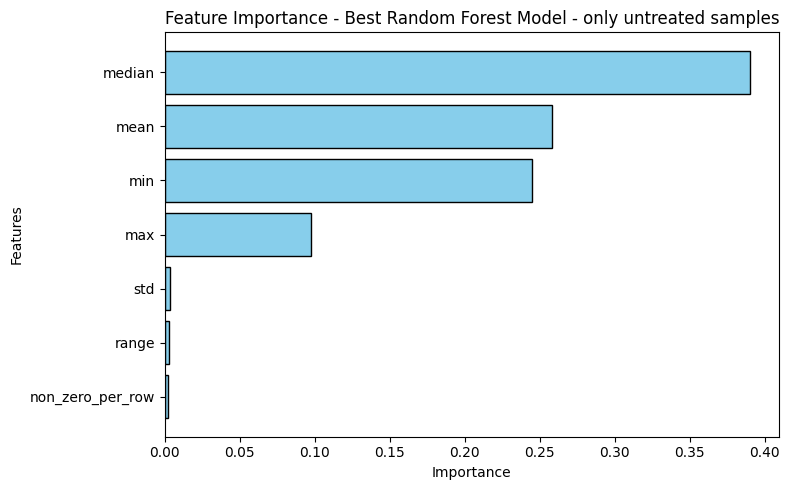

In [34]:
plt.figure(figsize=(8,5))
plt.barh(feat_importances["Feature"], feat_importances["Importance"], color="skyblue", edgecolor="black")
plt.title("Feature Importance - Best Random Forest Model - only untreated samples")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # 🔹 Per avere la più importante in alto
plt.tight_layout()
plt.show()